## Load in RHEED training data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow as tf
from qkeras import *
import hls4ml

2025-05-13 20:18:56.246370: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 20:18:56.451543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read H5 Data File:
data_dir = '/home/mattwilk/8bit6fractional/' # Change to your DATA PATH

RHEED_data_file = data_dir + 'RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_data_file, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.expand_dims(normalized_images, axis=-1).astype(np.float32) # if (batch_size, height, width, channels)
# normalized_images = np.expand_dims(normalized_images, axis=1).astype(np.float32) # if (batch_size, channels, height, width)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

[Normalized Images Shape]: (150985, 48, 48, 1)


[Normalized Image #12033]:


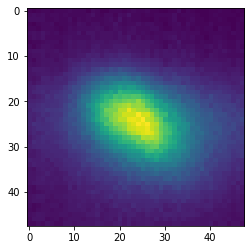

In [3]:
# Validate Data Array:
validate_data_array = 1

if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

### Useful functions

In [4]:
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))  

In [5]:
def custom_weighted_mse_loss(I, J, n):
    W = tf.pow(I, n)
    squared_diffs = tf.pow(I - J, 2)
    weighted_squared_diffs = W * squared_diffs

    return tf.reduce_mean(weighted_squared_diffs)

## Load the Model

I ran into some issues loading the QKeras model directly so I had to do this weird work around

In [6]:
# Model Architecture QAT
integer_bits = 2
fraction_bits = 6
symmetric = 0
keep_negative = 1

In [7]:
import tensorflow as tf
from qkeras import QConv2DBatchnorm, QActivation, QDense

def build_model(input_shape, total_bits, integer_bits):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = QConv2DBatchnorm(
        filters=6, kernel_size=5, strides=1, padding='valid',
        kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        use_bias=True,
    )(inputs)
    x = QActivation(f"quantized_relu({total_bits}, {integer_bits})")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=4, strides=4)(x)
    
    x = QConv2DBatchnorm(
        filters=16, kernel_size=5, strides=1, padding='valid',
        kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=tf.keras.regularizers.l1(0.0001),
        use_bias=True,
    )(x)
    x = QActivation(f"quantized_relu({total_bits}, {integer_bits})")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = QDense(
        units=98,
        kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
    )(x)
    x = QActivation(f"quantized_relu({total_bits}, {integer_bits})")(x)
    
    x = QDense(
        units=52,
        kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
    )(x)
    x = QActivation(f"quantized_relu({total_bits}, {integer_bits})")(x)
    
    outputs = QDense(
        units=5,
        kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
    )(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
input_shape = (48, 48, 1) 
total_bits = 8
integer_bits = 2

# Build the model
model = build_model(input_shape, total_bits, integer_bits)

# Compile the model
model.compile(optimizer='adam', loss=custom_weighted_mse_loss, run_eagerly=True)

# Display the model summary
model.summary()

2025-05-13 20:19:15.761741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:19:15.930205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:19:15.930637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:19:15.933603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:19:15.933891: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 q_conv2d_batchnorm (QConv2  (None, 44, 44, 6)         181       
 DBatchnorm)                                                     
                                                                 
 q_activation (QActivation)  (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 6)         0         
 D)                                                              
                                                                 
 q_conv2d_batchnorm_1 (QCon  (None, 7, 7, 16)          2481      
 v2DBatchnorm)                                                   
                                                             

In [9]:
dummy_input = tf.random.normal((1, 48, 48, 1))  
model.predict(dummy_input)  # Call the model once to initialize the weights

model.load_weights('/home/mattwilk/8bit6fractional/ml4fg/Gaussian_Model_QAT_2I_6F_weights.h5')  # Load Weights

2025-05-13 20:19:20.220773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-05-13 20:19:20.381037: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-05-13 20:19:20.382921: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-05-13 20:19:20.382944: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2025-05-13 20:19:20.382984: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 0s 444ms/step


2025-05-13 20:19:20.562855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## HLS4ML Conversion

In [10]:
io_type = 'io_stream'
backend = 'Vitis'
part = 'xcku035-fbva676-2-e'
OUT_DIR = f'RHEED_hls'

config = hls4ml.utils.config_from_keras_model (model,
                                                   default_precision = 'ap_fixed<8,2>',
                                                   granularity = 'name') # Import example CNN

config["LayerName"]["q_conv2d_batchnorm"]["ReuseFactor"] = 50
config["LayerName"]["q_conv2d_batchnorm"]["Strategy"] = "Resource"

config["LayerName"]["q_conv2d_batchnorm_1"]["ReuseFactor"] = 150
config["LayerName"]["q_conv2d_batchnorm_1"]["Strategy"] = "Resource"

config["LayerName"]["q_dense"]["ReuseFactor"] = 288
config["LayerName"]["q_dense"]["Strategy"] = "Resource"

config["LayerName"]["q_dense_1"]["ReuseFactor"] = 98
config["LayerName"]["q_dense_1"]["Strategy"] = "Resource"

config["LayerName"]["q_dense_2"]["ReuseFactor"] = 26
config["LayerName"]["q_dense_2"]["Strategy"] = "Resource"

print_dict(config)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 7, 7, 16]], output shape: [None, 3, 3, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 3, 3, 16]], output shape: [None, 144]
Layer name: q_dense, lay

In [11]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config = config,
                                                       io_type = io_type,
                                                       backend = backend,
                                                       output_dir = OUT_DIR,
                                                       part = part
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 7, 7, 16]], output shape: [None, 3, 3, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 3, 3, 16]], output shape: [None, 144]
Layer name: q_dense, lay

/home/mattwilk/anaconda3/envs/hls4ml_frame_grabber/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [12]:
hls_model.predict(np.full((1, 48, 48), 7).astype(float))

array([-0.46875 ,  0.109375,  1.90625 , -0.328125,  1.671875])

In [13]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'mattwilk' on host 'MattWorkstation.' (Linux_x86_64 version 5.15.167.4-microsoft-standard-WSL2) on Tue May 13 20:24:14 PDT 2025
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/mattwilk/8bit6fractional/RHEED_hls'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/mattwilk/8bit6fractional/RHEED_hls/myproject_prj'.
INFO: [HLS 200-1510] Running: set_top myproject 
INFO: [HLS 200-1510] Running: add_files firmware/myproject.cpp -cflags -s

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.263',
  'BestLatency': '131289',
  'WorstLatency': '131438',
  'IntervalMin': '9218',
  'IntervalMax': '131330',
  'BRAM_18K': '288',
  'DSP': '0',
  'FF': '18885',
  'LUT': '39208',
  'URAM': '0',
  'AvailableBRAM_18K': '1080',
  'AvailableDSP': '1700',
  'AvailableFF': '406256',
  'AvailableLUT': '203128',
  'AvailableURAM': '0'}}